*Luis Antonio Ortega Andrés   
Antonio Coín Castro*

# Classification using Random and Nyström features

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of Random Fourier features and Nystöm features with linear SVMs to carry out non-linear classification.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets, svm
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.gaussian_process.kernels import Matern

import kernel_approximation as ka

%load_ext autoreload
%autoreload 2

seed = 0
np.random.seed(seed)  # for reproducible results

In [2]:
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):
    """Plot decision regions of a classifier 'clf'."""
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)

    plt.imshow(Z, interpolation='nearest',
               extent=(grid_x1.min(), grid_x1.max(),
                       grid_x2.min(), grid_x2.max()),
               aspect='auto',
               origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0],
                           linewidths=2, linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y,
                cmap=plt.cm.Paired, edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1),
              np.min(grid_x2), np.max(grid_x2)])
    plt.show()

## Create dataset

In [3]:
"""
# A simple 2-D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""

# A not so simple 2-D problem

noise = 0.3

# Training set
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=seed)

# Test set
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions
grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)
grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

## Non-linear SVM (sklearn)

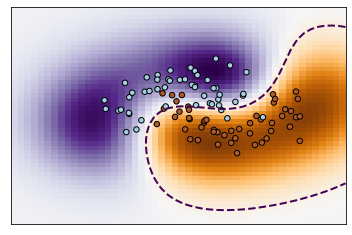

In [4]:
gamma = 0.5

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)
clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

## RBF Random Features (sklearn)

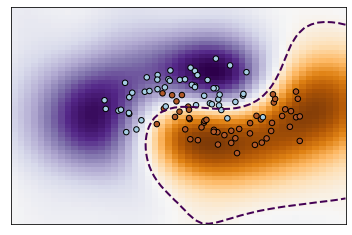

In [5]:
n_random_features = 10000

rbf_sampler = RBFSampler(
    gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## RBF Random Features (our implementation)

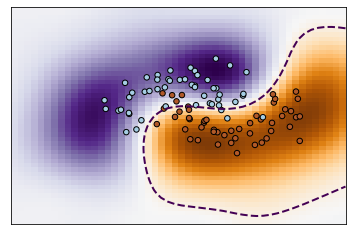

In [6]:
sigma = np.sqrt(1.0/2.0/gamma)

rbf_sampler = ka.RandomFeaturesSamplerRBF(n_random_features, sigma, seed)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## Matérn Random Features (our implementation)

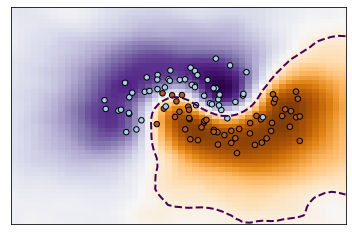

In [7]:
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(
    n_random_features, length_scale, nu, seed)
random_features = matern_sampler.fit_transform(X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

## Nyström features (our implementation)

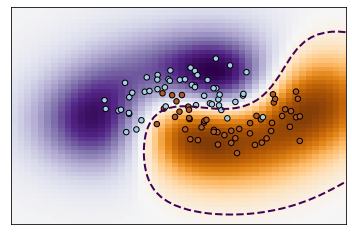

In [8]:
# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma)


n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(
    n_nystroem_features, kernel, seed)
nystroem_features = nystroem_sampler.fit_transform(X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Choosing the optimal hyperparameters and comparing the prediction error

Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, we determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers considered in the previous examples, using CV on the training set. We also compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 


In [9]:
# Scale data to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

# Set CV parameters
n_folds = 5
folds = StratifiedKFold(
    n_folds,
    shuffle=True,
    random_state=seed
)

# Build a Pipeline for each classifier
models = [
    (Pipeline([("svc_sk_rbf",
                    svm.SVC(kernel='rbf', random_state=seed))]),
     "Non-linear SVM (SKlearn)"),
    (Pipeline([("rbf_sk", RBFSampler(random_state=seed)),
               ("svc_sk_linear",
                    svm.SVC(kernel='linear', random_state=seed))]),
     "RBF Random Features (SKlearn) + Linear SVM"),
    (Pipeline([("rbf_features", 
                    ka.RandomFeaturesSamplerRBF(random_state=seed)),
               ("svc",
                    svm.SVC(kernel='linear', random_state=seed))]),
     "RBF Random Features (our implementation) + Linear SVM"),
    (Pipeline([("matern_features", 
                    ka.RandomFeaturesSamplerMatern(random_state=seed)),
               ("svc", 
                    svm.SVC(kernel='linear', random_state=seed))]),
     "Matérn Random Features (our implementation) + Linear SVM"),
    (Pipeline([("nystroem_rbf_features", 
                    ka.NystroemFeaturesSampler(random_state=seed)),
               ("svc", 
                    svm.SVC(kernel='linear', random_state=seed))]),
     "Nyström Features RBF (our implementation) + Linear SVM"),
    (Pipeline([("nystroem_matern_features", 
                    ka.NystroemFeaturesSampler(kernel=Matern(), 
                                               random_state=seed)),
               ("svc", 
                    svm.SVC(kernel='linear', random_state=seed))]),
     "Nyström Features Matérn (our implementation) + Linear SVM")
]

# Set parameter search space
gamma_logspace = np.logspace(-4, 4, 15)
sigma_logspace = np.sqrt(1.0/2.0/gamma_logspace)
nu_space = np.linspace(1, 4, 7)
n_features_space = [10, 20, 50, 70, 100, 500]

parameters = [
    # Non-linear SVM (SKlearn)
    {"svc_sk_rbf__gamma": gamma_logspace},
    # RBF Random Features (SKlearn) + Linear SVM
    {"rbf_sk__gamma": gamma_logspace,
     "rbf_sk__n_components": n_features_space},
    # RBF Random Features (our implementation) + Linear SVM
    {"rbf_features__sigma": sigma_logspace,
     "rbf_features__n_components": n_features_space},
    # Matérn Random Features (our implementation) + Linear SVM"
    {"matern_features__scale": sigma_logspace,
     "matern_features__nu": nu_space,
     "matern_features__n_components": n_features_space},
    # Nyström Features RBF (our implementation) + Linear SVM
    {"nystroem_rbf_features__n_components": n_features_space,
     "nystroem_rbf_features__kernel__length_scale": sigma_logspace},
    # Nyström Features Mátern (our implementation) + Linear SVM
    {"nystroem_matern_features__n_components": n_features_space,
     "nystroem_matern_features__kernel__length_scale": sigma_logspace,
     "nystroem_matern_features__kernel__nu": nu_space}
]

# Perform grid search
val_scores = []
for (model, name), param_grid in zip(models, parameters):
    print("--", name, "--")
    clf = GridSearchCV(
        model, 
        param_grid, 
        cv=folds)
    
    # Find best classifier
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=UserWarning)
        clf.fit(X, y)
    
    # Use best model (already refitted) to predict
    test_score = clf.score(X_test, y_test)
    
    print(f"  Test score: {test_score:.3f}")
    print("  Best parameters:\n    ", clf.best_params_)
    print("")

    # Save mean validation score for different n_components values
    idx = [k for k in clf.cv_results_.keys() if "n_components" in k]
    if idx:
        df = pd.DataFrame(clf.cv_results_)
        scores = \
            df.groupby(idx[0]).mean()["mean_test_score"].to_numpy()
        val_scores.append((scores, name))

-- Non-linear SVM (SKlearn) --
  Test score: 0.907
  Best parameters:
     {'svc_sk_rbf__gamma': 13.89495494373136}

-- RBF Random Features (SKlearn) + Linear SVM --
  Test score: 0.907
  Best parameters:
     {'rbf_sk__gamma': 13.89495494373136, 'rbf_sk__n_components': 500}

-- RBF Random Features (our implementation) + Linear SVM --
  Test score: 0.910
  Best parameters:
     {'rbf_features__n_components': 500, 'rbf_features__sigma': 0.18969523887029333}

-- Matérn Random Features (our implementation) + Linear SVM --
  Test score: 0.904
  Best parameters:
     {'matern_features__n_components': 100, 'matern_features__nu': 1.5, 'matern_features__scale': 0.18969523887029333}

-- Nyström Features RBF (our implementation) + Linear SVM --
  Test score: 0.907
  Best parameters:
     {'nystroem_rbf_features__kernel__length_scale': 0.18969523887029333, 'nystroem_rbf_features__n_components': 50}

-- Nyström Features Matérn (our implementation) + Linear SVM --
  Test score: 0.898
  Best paramet

Inspecting the results, we notice that given their best set of parameters, all the considered methods perform reasonably well and give similar results. The highest difference in score (on the test set) is $0.012$ between RBF random features and Nyström with Matérn kernel. In general, the combination of Random/Nyström features and linear SVM outperforms the non-linear SVM.

It is woth mentioning that all the methods found the same optimal gamma/sigma parameter, which are $13.9$ and $0.189$ respectively. On the other hand, the optimal number of features varies from one method to another, from 50 to 100 to 500. We also notice that the optimal parameters for the Matérn kernel are equal when using the Nyström method or Random features, and the optimal number of features is the same for the Nyström method regardless of the kernel used.

To exemplify the results, we can plot a graph depicting the evolution of the mean validation score for every fold versus the number of features sampled.

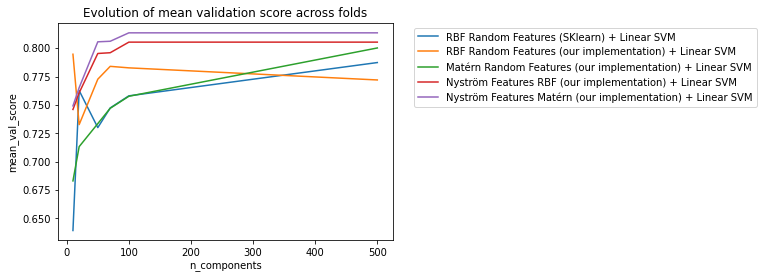

In [11]:
for scores, name in val_scores:
    plt.title("Evolution of mean validation score across folds")
    plt.xlabel("n_components")
    plt.ylabel("mean_val_score")
    plt.plot(n_features_space, scores, label=name)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Note that the line for Nyström is constant from 100 features onwards, since it is restricted by the size of the training set (which is 100).